In [1]:
import pandas as pd, numpy as np, scipy as sp, random as rn
import seaborn as sns, matplotlib.pyplot as plt
import json, os, gc, time, re, cv2, glob
from math import sqrt

from joblib import Parallel, delayed

from functools import partial
from math import sqrt
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.linear_model import Ridge

from keras.applications.densenet import preprocess_input, DenseNet121
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda
from keras.layers import Lambda, Concatenate, AveragePooling1D, MaxPooling1D
from keras.models import Model
import keras.backend as K

from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from textblob import TextBlob
import scipy as sp
from collections import Counter

from bayes_opt import BayesianOptimization

from collections import Counter, defaultdict
import lightgbm as lgbm

import xgboost as xgb

seed = 32
np.random.seed(seed)
rn.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

stop_words = list(set(stopwords.words("english")))
punctuation = string.punctuation

train = pd.read_csv("../input/petfinder-adoption-prediction/train/train.csv")
test = pd.read_csv("../input/petfinder-adoption-prediction/test/test.csv")

Using TensorFlow backend.


In [2]:
target = train["AdoptionSpeed"]
rescuerID = train["RescuerID"]
train.drop(["AdoptionSpeed"], axis = 1, inplace = True)

In [3]:
breeds = pd.read_csv("../input//petfinder-adoption-prediction/breed_labels.csv")
breeds_dict = {k:v for k, v in zip(breeds["BreedID"], breeds["BreedName"])}

train["Breed1Name"] = train["Breed1"].apply(lambda x: breeds_dict[x] if x in breeds_dict else "Unknown")
test["Breed1Name"] = test["Breed1"].apply(lambda x: breeds_dict[x] if x in breeds_dict else "Unknown")

train["Breed2Name"] = train["Breed2"].apply(lambda x: breeds_dict[x] if x in breeds_dict else "Unknown")
test["Breed2Name"] = test["Breed2"].apply(lambda x: breeds_dict[x] if x in breeds_dict else "Unknown")

In [4]:
for cat in ["Vaccinated", "Dewormed", "Sterilized", "Health"]:
    train[cat] = train[cat].apply(lambda x: 1 if x == 1 else 0)
    test[cat] = test[cat].apply(lambda x: 1 if x == 1 else 0)

In [5]:
# train["Fee"] = np.log(train["Fee"] + 1)
# test["Fee"] = np.log(test["Fee"] + 1)

In [6]:
def add_count_feat(data, cols):
    feat_name = "_".join(cols) + "_count"
    arr_slice = data[cols].values
    unq, unqtags, counts = np.unique(np.ravel_multi_index(arr_slice.T, arr_slice.max(0) + 1),
                                     return_inverse = True, return_counts = True)
    data[feat_name] = counts[unqtags]
    del arr_slice, unq, unqtags, counts; gc.collect()
    
    return data

train = add_count_feat(train, ["Breed1", "State"])
train = add_count_feat(train, ["Breed1", "Age"])
train = add_count_feat(train, ["Type", "State"])
train["RescuerID_count"] = train["RescuerID"].map(train["RescuerID"].value_counts())
train["RescuerID_Breed1_count"] = train["RescuerID"].map(train[["RescuerID", "Breed1"]].groupby("RescuerID")["Breed1"].count())
train["State_rescuer_count"] = train["State"].map(train[["State", "RescuerID"]].groupby("State")["RescuerID"].count())

test = add_count_feat(test, ["Breed1", "State"])
test = add_count_feat(test, ["Breed1", "Age"])
test = add_count_feat(test, ["Type", "State"])
test["RescuerID_count"] = test["RescuerID"].map(test["RescuerID"].value_counts())
test["RescuerID_Breed1_count"] = test["RescuerID"].map(test[["RescuerID", "Breed1"]].groupby("RescuerID")["Breed1"].count())
test["State_rescuer_count"] = test["State"].map(test[["State", "RescuerID"]].groupby("State")["RescuerID"].count())

count_feats = ["Breed1_State_count", "Breed1_Age_count", "Type_State_count", 
               "RescuerID_Breed1_count", "RescuerID_count", "State_rescuer_count"]

In [7]:
train["DescriptionLen"] = train["Description"].fillna("No Description").apply(len)
test["DescriptionLen"] = test["Description"].fillna("No Description").apply(len)

In [8]:
def add_agg_feats(dataframe):
    aggs = {}
    aggs["Age"] = ["mean", "std", "median", "var"]
    aggs["Fee"] = ["mean", "std", "median", "var"]
    aggs["Quantity"] = ["mean", "std", "median", "var"]
    aggs["PhotoAmt"] = ["mean", "std", "median", "var"]
    aggs["VideoAmt"] = ["mean", "std", "var"]
    aggs["DescriptionLen"] = ["mean", "std", "median", "var"]
    aggs["Vaccinated"] = ["sum"]
    aggs["Dewormed"] = ["sum"]
    aggs["Sterilized"] = ["sum"]
    aggs["Health"] = ["sum"]
    
    for col in [["Breed1"], ["RescuerID"], ["State"], ["RescuerID", "State"], 
                ["RescuerID", "Breed1"], ["RescuerID", "Gender"], ["Breed1", "Breed2"]]:
        agg_feat = dataframe.groupby(col).agg(aggs)
        agg_feat.columns = ["".join(col) + "_" + "_".join(c) for c in agg_feat.columns.values]
        agg_feat = agg_feat[agg_feat.columns].fillna(-1)
        agg_feat.reset_index(inplace = True)
        dataframe = pd.merge(dataframe, agg_feat, on = col, how = "left")
        
    return dataframe

num_feat = len(train.columns)
train = add_agg_feats(train)
test = add_agg_feats(test)
agg_feats = list(train.columns[num_feat:])

In [9]:
def get_sentiment(file_path, df):
    file_path = file_path + df["PetID"] + ".json"
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            file = json.load(f)
        doc_sent_mag = file["documentSentiment"]["magnitude"]
        doc_sent_score = file["documentSentiment"]["score"]
        file_entities = [x["name"] for x in file["entities"]]
        entities = " ".join(file_entities)
        
        file_sentences_sentiment = [x["sentiment"] for x in file["sentences"]]
        file_sentences_sentiment = pd.DataFrame.from_dict(file_sentences_sentiment, 
                                                          orient = "columns")
        sentiment_mag_sum = file_sentences_sentiment["magnitude"].sum(axis = 0)
        sentiment_mag_mean = file_sentences_sentiment["magnitude"].mean(axis = 0)
        sentiment_mag_std = file_sentences_sentiment["magnitude"].std(axis = 0)
        
        sentiment_score_sum = file_sentences_sentiment["score"].sum(axis = 0)
        sentiment_score_mean = file_sentences_sentiment["score"].mean(axis = 0)
        sentiment_score_std = file_sentences_sentiment["score"].std(axis = 0)
        return pd.Series([doc_sent_mag, doc_sent_score, entities, 
                          sentiment_mag_sum, sentiment_mag_mean,
                          sentiment_score_sum, sentiment_score_mean,
                          sentiment_mag_std, sentiment_score_std], 
                         index = ["doc_sent_mag", "doc_sent_score", "entities", 
                                  "sentiment_mag_sum", "sentiment_mag_mean",
                                  "sentiment_score_sum", "sentiment_score_mean",
                                  "sentiment_mag_std", "sentiment_score_std"])
    else:
        return pd.Series([-1, -1, "No Entities", -1, -1, -1, -1, -1, -1], 
                         index = ["doc_sent_mag", "doc_sent_score", "entities", 
                                  "sentiment_mag_sum", "sentiment_mag_mean",
                                  "sentiment_score_sum", "sentiment_score_mean",
                                  "sentiment_mag_std", "sentiment_score_std"])

train_path = "../input/petfinder-adoption-prediction/train_sentiment/"
test_path = "../input/petfinder-adoption-prediction/test_sentiment/"

train[["doc_sent_mag", "doc_sent_score", "entities", 
       "sentiment_mag_sum", "sentiment_mag_mean",
       "sentiment_score_sum", "sentiment_score_mean",
       "sentiment_mag_std", "sentiment_score_std"]] = train[["PetID"]].apply(lambda pet_id: get_sentiment(train_path, pet_id), axis = 1)
test[["doc_sent_mag", "doc_sent_score", "entities", 
      "sentiment_mag_sum", "sentiment_mag_mean",
      "sentiment_score_sum", "sentiment_score_mean",
      "sentiment_mag_std", "sentiment_score_std"]] = test[["PetID"]].apply(lambda pet_id: get_sentiment(test_path, pet_id), axis = 1)

In [10]:
class PetFinderParser(object):
    def __init__(self):
        None
        
    def open_json_file(self, file_path):
        with open(file_path, "r", encoding = "utf-8") as f:
            file_data = json.load(f)
        return file_data
    
    def get_metadata(self, file_data):
    
        file_keys = list(file_data.keys())
    
        if "labelAnnotations" in file_keys:
            file_annots = file_data["labelAnnotations"][:int(len(file_data["labelAnnotations"])*0.3)]
            file_top_score = np.asarray([x["score"] for x in file_annots]).mean()
            file_top_topicality = np.asarray([x["topicality"] for x in file_annots]).mean()
            file_top_desc = [x["description"] for x in file_annots]
        else:
            file_top_score = 0
            file_top_topicality = 0
            file_top_desc = [""]
        
        file_colors = file_data["imagePropertiesAnnotation"]["dominantColors"]["colors"]
        file_crops = file_data["cropHintsAnnotation"]["cropHints"]
        file_color_score = np.asarray([x["score"] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x["pixelFraction"] for x in file_colors]).mean()
        file_crop_conf = np.asarray([x["confidence"] for x in file_crops]).mean()
        
        try:
            file_color_red = np.asarray([x["color"]["red"] for x in file_colors]).mean()
            file_color_green = np.asarray([x["color"]["green"] for x in file_colors]).mean()
            file_color_blue = np.asarray([x["color"]["blue"] for x in file_colors]).mean()
        except:
            file_color_red = 0
            file_color_green = 0
            file_color_blue = 0
            
        if "boundingPoly" in file_crops[0].keys():
            verterx_x = np.array([x["boundingPoly"]["vertices"][2]["x"] for x in file_crops]).mean()
            verterx_y = np.array([x["boundingPoly"]["vertices"][2]["y"] for x in file_crops]).mean()
        else:
            verterx_x = 0
            verterx_y = 0
            
        if "importanceFraction" in file_crops[0].keys():
            file_crop_importance = np.asarray([x["importanceFraction"] for x in file_crops]).mean()
        else:
            file_crop_importance = 0
        
        metadata = {"annot_score": file_top_score,
                    "annot_topicality": file_top_topicality,
                    "red": file_color_red,
                    "green": file_color_green,
                    "blue": file_color_blue,
                    "verterx_x": verterx_x,
                    "verterx_y": verterx_y,
                    "annot_desc": " ".join(file_top_desc),
                    "color_score": file_color_score,
                    "color_pixelfrac": file_color_pixelfrac,
                    "crop_confidence": file_crop_conf,
                    "crop_importance": file_crop_importance}
    
        metadata_df = pd.DataFrame.from_dict(metadata, orient = "index").T
        metadata_df = metadata_df.add_prefix("metadata_")
    
        return metadata_df

def extract_metadata(mode = "", pet_id = ""):
    metadata_dfs = []
    file_name = "../input/petfinder-adoption-prediction/{}_metadata/{}*.json".format(mode, pet_id)
    metadata_file_names = sorted(glob.glob(file_name))
    
    if len(metadata_file_names) > 0:
        for file in metadata_file_names:
            file_data = pet_parser.open_json_file(file)
            partial_metadata = pet_parser.get_metadata(file_data)
            partial_metadata["PetID"] = pet_id
            metadata_dfs.append(partial_metadata)
        metadata_dfs = pd.concat(metadata_dfs, ignore_index = True, sort = False)
        
    return metadata_dfs

pet_parser = PetFinderParser()

In [11]:
train_metadata = Parallel(n_jobs = 6, 
                          verbose = 1)(delayed(extract_metadata)(mode = "train", pet_id = pet_id) 
                                       for pet_id in train["PetID"].values)
train_metadata = [pd.DataFrame(metadata) for metadata in train_metadata]
train_metadata = pd.concat(train_metadata, ignore_index = True, sort = False)

test_metadata = Parallel(n_jobs = 6, 
                         verbose = 1)(delayed(extract_metadata)(mode = "test", pet_id = pet_id)
                                       for pet_id in test["PetID"].values)
test_metadata = [pd.DataFrame(metadata) for metadata in test_metadata]
test_metadata = pd.concat(test_metadata, ignore_index = True, sort = False)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   10.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   39.4s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 12.8mi

In [12]:
def agg_metadata(metadata):
    aggre = ["mean", "sum", "median", "std"]
    metadata_desc = metadata.groupby(["PetID"])["metadata_annot_desc"].unique()
    metadata_desc = metadata_desc.reset_index()
    metadata_desc["metadata_annot_desc"] = metadata_desc["metadata_annot_desc"].apply(lambda x: " ".join(x))
    
    metadata = metadata.drop(["metadata_annot_desc"], axis = 1)
    for col in metadata.columns:
        if "PetID" not in col:
            metadata[col] = metadata[col].astype(float)
    metadata_agg = metadata.groupby(["PetID"]).agg(aggre)
    metadata_agg.columns = pd.Index(["{}_{}_{}".format("metadata", c[0], c[1].upper()) for c in metadata_agg.columns.tolist()])
    metadata_agg = metadata_agg.reset_index()
    
    return metadata_desc, metadata_agg

train_meta_desc, train_meta_agg = agg_metadata(train_metadata)
test_meta_desc, test_meta_agg = agg_metadata(test_metadata)

meta_agg_feats = list(train_meta_agg.columns)

In [13]:
train = train.merge(train_meta_desc, how = "left", on = "PetID")
train = train.merge(train_meta_agg, how = "left", on = "PetID")

test = test.merge(test_meta_desc, how = "left", on = "PetID")
test = test.merge(test_meta_agg, how = "left", on = "PetID")

train[train_meta_agg.columns] = train[train_meta_agg.columns].fillna(-1)
test[train_meta_agg.columns] = test[train_meta_agg.columns].fillna(-1)

del train_meta_desc, train_meta_agg, test_meta_desc, test_meta_agg; gc.collect()

112

In [14]:
train_desc = train["entities"].fillna("no entity")
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(train_desc)
train_tfidf = tfidf_vec.transform(train_desc)
print(train_tfidf.shape)

svd_components = 10
svd = TruncatedSVD(n_components = svd_components, random_state = seed)
svd.fit(train_tfidf)
train_tfidf_svd = svd.transform(train_tfidf)

test_desc = test["entities"].fillna("no entity")
test_tfidf = tfidf_vec.transform(test_desc)
test_tfidf_svd = svd.transform(test_tfidf)

train_tfidf_svd = pd.DataFrame(train_tfidf_svd, columns = ["enti_tfitf_svd_{}".format(i) for i in range(svd_components)])
train = pd.concat([train, train_tfidf_svd], axis = 1)
test_tfidf_svd = pd.DataFrame(test_tfidf_svd, columns = ["enti_tfitf_svd_{}".format(i) for i in range(svd_components)])
test = pd.concat([test, test_tfidf_svd], axis = 1)

enti_tfidf_svd_feats = list(train_tfidf_svd.columns)

nmf = NMF(n_components = svd_components, random_state = seed)
nmf.fit(train_tfidf)
train_tfidf_nmf = nmf.transform(train_tfidf)
test_tfidf_nmf = nmf.transform(test_tfidf)

train_tfidf_nmf = pd.DataFrame(train_tfidf_nmf, columns = ["enti_tfitf_nmf_{}".format(i) for i in range(svd_components)])
train = pd.concat([train, train_tfidf_nmf], axis = 1)
test_tfidf_nmf = pd.DataFrame(test_tfidf_nmf, columns = ["enti_tfitf_nmf_{}".format(i) for i in range(svd_components)])
test = pd.concat([test, test_tfidf_nmf], axis = 1)

enti_tfidf_nmf_feats = list(train_tfidf_nmf.columns)

train.drop(["entities"], axis = 1, inplace = True); gc.collect()
test.drop(["entities"], axis = 1, inplace = True); gc.collect()
del train_tfidf, test_tfidf, train_tfidf_svd, test_tfidf_svd; gc.collect()
del train_tfidf_nmf, test_tfidf_nmf; gc.collect()

(14993, 12306)


0

In [15]:
train_desc = train["metadata_annot_desc"].fillna("no description").values
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(train_desc)
train_tfidf = tfidf_vec.transform(train_desc)
print(train_tfidf.shape)

svd_components = 10
svd = TruncatedSVD(n_components = svd_components, random_state = seed)
svd.fit(train_tfidf)
train_tfidf_svd = svd.transform(train_tfidf)

test_desc = test["metadata_annot_desc"].fillna("no description").values
test_tfidf = tfidf_vec.transform(test_desc)
test_tfidf_svd = svd.transform(test_tfidf)

train_tfidf_svd = pd.DataFrame(train_tfidf_svd, columns = ["meta_tfitf_svd_{}".format(i) for i in range(svd_components)])
train = pd.concat([train, train_tfidf_svd], axis = 1)
test_tfidf_svd = pd.DataFrame(test_tfidf_svd, columns = ["meta_tfitf_svd_{}".format(i) for i in range(svd_components)])
test = pd.concat([test, test_tfidf_svd], axis = 1)

meta_tfidf_svd_feats = list(train_tfidf_svd.columns)

nmf = NMF(n_components = svd_components, random_state = seed)
nmf.fit(train_tfidf)
train_tfidf_nmf = nmf.transform(train_tfidf)
test_tfidf_nmf = nmf.transform(test_tfidf)

train_tfidf_nmf = pd.DataFrame(train_tfidf_nmf, columns = ["meta_tfitf_nmf_{}".format(i) for i in range(svd_components)])
train = pd.concat([train, train_tfidf_nmf], axis = 1)
test_tfidf_nmf = pd.DataFrame(test_tfidf_nmf, columns = ["meta_tfitf_nmf_{}".format(i) for i in range(svd_components)])
test = pd.concat([test, test_tfidf_nmf], axis = 1)

meta_tfidf_nmf_feats = list(train_tfidf_nmf.columns)

train.drop(["metadata_annot_desc"], axis = 1, inplace = True); gc.collect()
test.drop(["metadata_annot_desc"], axis = 1, inplace = True); gc.collect()
del train_tfidf, test_tfidf, train_tfidf_svd, test_tfidf_svd; gc.collect()
del train_tfidf_nmf, test_tfidf_nmf; gc.collect()

(14993, 429)


0

In [16]:
train_desc = train["Description"].fillna("no description").values
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(train_desc)
train_tfidf = tfidf_vec.transform(train_desc)

svd_components = 30
svd = TruncatedSVD(n_components = svd_components, random_state = seed)
svd.fit(train_tfidf)
train_tfidf_svd = svd.transform(train_tfidf)
print(train_tfidf.shape)

test_desc = test["Description"].fillna("no description").values
test_tfidf = tfidf_vec.transform(test_desc)
test_tfidf_svd = svd.transform(test_tfidf)

train_tfidf_svd = pd.DataFrame(train_tfidf_svd, columns = ["tfitf_svd_{}".format(i) for i in range(svd_components)])
train = pd.concat([train, train_tfidf_svd], axis = 1)
test_tfidf_svd = pd.DataFrame(test_tfidf_svd, columns = ["tfitf_svd_{}".format(i) for i in range(svd_components)])
test = pd.concat([test, test_tfidf_svd], axis = 1)

tfidf_svd_feats = list(train_tfidf_svd.columns)

nmf = NMF(n_components = svd_components, random_state = seed)
nmf.fit(train_tfidf)
train_tfidf_nmf = nmf.transform(train_tfidf)
test_tfidf_nmf = nmf.transform(test_tfidf)

train_tfidf_nmf = pd.DataFrame(train_tfidf_nmf, columns = ["tfitf_nmf_{}".format(i) for i in range(svd_components)])
train = pd.concat([train, train_tfidf_nmf], axis = 1)
test_tfidf_nmf = pd.DataFrame(test_tfidf_nmf, columns = ["tfitf_nmf_{}".format(i) for i in range(svd_components)])
test = pd.concat([test, test_tfidf_nmf], axis = 1)

tfidf_nmf_feats = list(train_tfidf_nmf.columns)

train.drop(["Description"], axis = 1, inplace = True); gc.collect()
test.drop(["Description"], axis = 1, inplace = True); gc.collect()
del train_tfidf, test_tfidf, train_tfidf_svd, test_tfidf_svd; gc.collect()
del train_tfidf_nmf, test_tfidf_nmf; gc.collect()

(14993, 21209)


0

In [17]:
train["Name"] = train["Name"].replace(["", "No Name", "No Name Yet"], "No Name")
test["Name"] = test["Name"].replace(["", "No Name", "No Name Yet"], "No Name")

In [18]:
train_comb = train[["Name", "Breed1Name", "Breed2Name", "RescuerID"]].astype(str).apply(lambda x: " ".join(x), axis = 1)
test_comb = test[["Name", "Breed1Name", "Breed2Name", "RescuerID"]].astype(str).apply(lambda x: " ".join(x), axis = 1)

tfidf_vec = TfidfVectorizer(min_df = 2, ngram_range = (1, 3))
tfidf_vec.fit(train_comb)
train_comb_vec = tfidf_vec.transform(train_comb)
test_comb_vec = tfidf_vec.transform(test_comb)
print(train_comb_vec.shape)

lad_components = 10
lda = LatentDirichletAllocation(n_components = lad_components, random_state = seed)
lda.fit(train_comb_vec)
train_comb_lda = lda.transform(train_comb_vec)
test_comb_lda = lda.transform(test_comb_vec)

train_comb_lda = pd.DataFrame(train_comb_lda, columns = ["lda_{}".format(i) for i in range(lad_components)])
train = pd.concat([train, train_comb_lda], axis = 1)
test_comb_lda = pd.DataFrame(test_comb_lda, columns = ["lda_{}".format(i) for i in range(lad_components)])
test = pd.concat([test, test_comb_lda], axis = 1)

lda_feats = list(train_comb_lda.columns)
del train_comb_vec, test_comb_vec, train_comb_lda, test_comb_lda; gc.collect()

(14993, 12941)


32

In [19]:
import tensorflow as tf
session_conf = tf.ConfigProto(intra_op_parallelism_threads = 1,
                              inter_op_parallelism_threads = 1)
tf.set_random_seed(seed)
sess = tf.Session(graph = tf.get_default_graph(), config = session_conf)
from keras import backend as K
K.set_session(sess)

image_size = 256
batch_size = 128

def resize_to_square(image, image_size = image_size):
    old_size = image.shape[:2]
    ratio = float(image_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))
    delta_w = image_size - new_size[1]
    delta_h = image_size - new_size[0]
    top, bottom = delta_h//2, delta_h - (delta_h//2)
    left, right = delta_w//2, delta_w - (delta_w//2)
    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value = color)
    return new_image

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

inp = Input((image_size, image_size, 3))
backbone = DenseNet121(input_tensor = inp, 
                       weights = "../input/densenet-keras/DenseNet-BC-121-32-no-top.h5",
                       include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x, axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:, :, 0])(x)
image_model = Model(inp, out)

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
def get_image_features(file_path, pet_ids, image_model = image_model, batch_size = batch_size):
    image_features = {}
    n_batches = len(pet_ids)//batch_size + 1
    for b in range(n_batches):
        start = b*batch_size
        end = (b+1)*batch_size
        batch_pets = pet_ids[start:end]
        batch_images = np.zeros((len(batch_pets),image_size, image_size, 3))
        for i, pet_id in enumerate(batch_pets):
            try:
                batch_images[i] = load_image(file_path, pet_id)
            except:
                pass
            
        batch_preds = image_model.predict(batch_images)
        for i, pet_id in enumerate(batch_pets):
            image_features[pet_id] = batch_preds[i]
            
    return image_features

train_image_path = "../input/petfinder-adoption-prediction/train_images/"
test_image_path = "../input/petfinder-adoption-prediction/test_images/"

train_image_features = get_image_features(train_image_path, train["PetID"].values)
test_image_features = get_image_features(test_image_path, test["PetID"].values)

In [21]:
train_image_feat = pd.DataFrame.from_dict(train_image_features, orient = "index")
train_image_feat.columns = ["pic_{}".format(i) for i in range(train_image_feat.shape[1])]
pic_features = train_image_feat.columns

train_image_feat = train_image_feat.reset_index()
train_image_feat.rename({"index": "PetID"}, axis = "columns", inplace = True)

test_image_feat = pd.DataFrame.from_dict(test_image_features, orient = "index")
test_image_feat.columns = ["pic_{}".format(i) for i in range(test_image_feat.shape[1])]
test_image_feat = test_image_feat.reset_index()
test_image_feat.rename({"index": "PetID"}, axis = "columns", inplace = True)

In [22]:
pic_features = ["pic_{}".format(i) for i in range(256)]
svd = TruncatedSVD(n_components = 32, random_state = seed)
svd.fit(train_image_feat[pic_features])

train_image_feat_svd = svd.transform(train_image_feat[pic_features])
test_image_feat_svd = svd.transform(test_image_feat[pic_features])

In [23]:
train_image_feat_svd = pd.DataFrame(train_image_feat_svd, columns = ["pic_svd_{}".format(i) for i in range(32)])
train = pd.concat([train, train_image_feat_svd], axis = 1)
test_image_feat_svd = pd.DataFrame(test_image_feat_svd, columns = ["pic_svd_{}".format(i) for i in range(32)])
test = pd.concat([test, test_image_feat_svd], axis = 1)

image_svd_feat = list(train_image_feat_svd.columns)

In [24]:
# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [25]:
# class OptimizedRounder(object):
#     def __init__(self):
#         self.coef_ = 0

#     def _kappa_loss(self, coef, X, y):
#         X_p = np.copy(X)
#         for i, pred in enumerate(X_p):
#             if pred < coef[0]:
#                 X_p[i] = 0
#             elif pred >= coef[0] and pred < coef[1]:
#                 X_p[i] = 1
#             elif pred >= coef[1] and pred < coef[2]:
#                 X_p[i] = 2
#             elif pred >= coef[2] and pred < coef[3]:
#                 X_p[i] = 3
#             else:
#                 X_p[i] = 4

#         ll = quadratic_weighted_kappa(y, X_p)
#         return -ll

#     def fit(self, X, y):
#         loss_partial = partial(self._kappa_loss, X=X, y=y)
#         initial_coef = [0.5, 1.5, 2.5, 3.5]
#         self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

#     def predict(self, X, coef):
#         X_p = np.copy(X)
#         for i, pred in enumerate(X_p):
#             if pred < coef[0]:
#                 X_p[i] = 0
#             elif pred >= coef[0] and pred < coef[1]:
#                 X_p[i] = 1
#             elif pred >= coef[1] and pred < coef[2]:
#                 X_p[i] = 2
#             elif pred >= coef[2] and pred < coef[3]:
#                 X_p[i] = 3
#             else:
#                 X_p[i] = 4
#         return X_p

#     def coefficients(self):
#         return self.coef_['x']
    
# def rmse(actual, predicted):
#     return sqrt(mean_squared_error(actual, predicted))

In [26]:
def metric_function(y1, y2):
    return cohen_kappa_score(y1, y2, weights = 'quadratic')

def get_class_bounds(y, y_pred, N = 5, class0_fraction = -1):
    ysort = np.sort(y)
    predsort = np.sort(y_pred)
    bounds = []
    for ibound in range(N-1):
        iy = len(ysort[ysort <= ibound])
        # adjust the number of class 0 predictions?
        if (ibound == 0) and (class0_fraction >= 0.0) :
            iy = int(class0_fraction * iy)
        bounds.append(predsort[iy])
    return bounds

def assign_class(y_pred, boundaries):
    """
    Given class boundaries in y_pred units, output integer class values
    """
    y_classes = np.zeros(len(y_pred))
    for iclass, bound in enumerate(boundaries):
        y_classes[y_pred >= bound] = iclass + 1
    return y_classes.astype(int)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metric_function(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        
        cl0fracs = np.array(np.arange(0.01, 1.001, 0.01))
        boundaries = []
        kappas = []
        for cl0frac in cl0fracs:
            boundary = get_class_bounds(y, X, class0_fraction = cl0frac)
            train_meta_ints = assign_class(X, boundary)
            kappa = metric_function(y, train_meta_ints)
            kappas.append(kappa)
            boundaries.append(boundary)
        max_kappa_index = np.array(kappas).argmax()
        initial_coef = boundaries[max_kappa_index]
        
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [27]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    rn.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [28]:
num_feat = ["Age", "VideoAmt", "PhotoAmt", "Quantity", "Fee", "doc_sent_mag", "doc_sent_score", 
            "sentiment_mag_sum", "sentiment_mag_mean", "sentiment_score_sum", 
            "sentiment_score_mean", "sentiment_mag_std", "sentiment_score_std"]
num_feat = num_feat + agg_feats
num_feat = num_feat + count_feats + meta_agg_feats + meta_tfidf_svd_feats + meta_tfidf_nmf_feats
num_feat = num_feat + enti_tfidf_svd_feats + enti_tfidf_nmf_feats
num_feat = num_feat + tfidf_svd_feats + image_svd_feat + lda_feats + tfidf_nmf_feats 
cat_feat = ["Type", "Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3", "MaturitySize",
            "FurLength", "Vaccinated", "Dewormed", "Sterilized", "Health", "State"]
predictors = list(set(num_feat + cat_feat))
if "PetID" in predictors:
    predictors.remove("PetID")

train[cat_feat] = train[cat_feat].astype("category")
train[cat_feat] = train[cat_feat].astype("category")
train_X = train[predictors].copy()

test[cat_feat] = test[cat_feat].astype("category")
test[cat_feat] = test[cat_feat].astype("category")

In [29]:
params = {"application": "regression",
          "boosting": "gbdt",
          "metric": "rmse",
          "num_leaves": 148,
          "max_depth": 10,
          "max_bin": 100,
          "learning_rate": 0.005,
          "bagging_fraction": 0.5990938273073173,
          "bagging_freq": 2,
          "feature_fraction": 0.5278792488192297,
          "min_split_gain": 0.6903990402559842,
          "lambda_l2": 0.273711000439522,
          "min_child_samples": 149,
          "min_child_weight": 0.09405871593756554,
          "verbosity": -1,
          "num_threads": 4,
          "seed": seed}

lgbm_oof_pred = np.zeros((train.shape[0]))
max_rounds = 10000
fold = 10
coeffs = pd.DataFrame()
lgbm_test_pred = 0
feature_importances = pd.DataFrame(np.zeros((1, len(predictors))), 
                                  columns = predictors)
plot_importance = True

# kfold = StratifiedKFold(n_splits = fold, random_state = seed, shuffle = True)
# kfold = GroupKFold(n_splits = fold)

# for i, (train_idx, val_idx) in enumerate(kfold.split(train_X, rescuerID)):
# for i, (train_idx, val_idx) in enumerate(kfold.split(train_X, target, rescuerID)):
for i, (train_idx, val_idx) in enumerate(stratified_group_k_fold(train_X, target, rescuerID, fold, seed = seed)):
    print("\n","-"*70)
    print("Train & Predict {}/{}".format(i+1, fold))
    
    evals_results = {}
    X_train, y_train = train_X.iloc[train_idx], target[train_idx]
    X_val, y_val = train_X.iloc[val_idx], target[val_idx]
    
    dtrain = lgbm.Dataset(X_train, label = y_train)
    dval = lgbm.Dataset(X_val, label = y_val)
    del X_train, y_train; gc.collect()
    
    model = lgbm.train(params, dtrain, valid_sets = [dtrain, dval], 
                       valid_names = ["train", "val"], evals_result = evals_results,
#                        categorical_feature = cat_feat,
                       num_boost_round = max_rounds, early_stopping_rounds = 500,
                       verbose_eval = 100)
    del dtrain, dval; gc.collect()
    
    n_estimator = model.best_iteration
    val_pred = model.predict(X_val, num_iteration = n_estimator)
    lgbm_oof_pred[val_idx] = val_pred
#     model_feat_importrance = pd.DataFrame()
#     model_feat_importrance["feat_name"] = model.feature_name()
#     model_feat_importrance["feat_gain"] = model.feature_importance(importance_type = "gain")
#     model_feat_importrance = model_feat_importrance.sort_values(by = "feat_gain", ascending = False)
    
#     feature_importances["Fold_{}_features".format(i)] = model_feat_importrance["feat_name"]
#     feature_importances["Fold_{}_importances".format(i)] = model_feat_importrance["feat_gain"]
    
    if plot_importance:
        feature_importances[model.feature_name()] += model.feature_importance(importance_type = "gain")/fold
    opt_round = OptimizedRounder()
    opt_round.fit(val_pred, y_val)
    coefficients = opt_round.coefficients()
    coeffs["Fold_{}_coeffs".format(i)] = coefficients
    val_pred = opt_round.predict(val_pred, coefficients)
    print("Valid Counts = ", Counter(y_val))
    print("Prediction Counts = ", Counter(val_pred))
    qwk = quadratic_weighted_kappa(y_val, val_pred)
    print("QWK score is {}".format(qwk))
    del X_val, y_val; gc.collect()
    
    lgbm_test_pred += model.predict(test[predictors], num_iteration = n_estimator)
    
lgbm_test_pred = lgbm_test_pred*1.0/fold


 ----------------------------------------------------------------------
Train & Predict 1/10


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.10158	val's rmse: 1.1176
[200]	train's rmse: 1.05472	val's rmse: 1.0868
[300]	train's rmse: 1.02178	val's rmse: 1.06938
[400]	train's rmse: 0.996461	val's rmse: 1.0587
[500]	train's rmse: 0.975458	val's rmse: 1.05249
[600]	train's rmse: 0.957631	val's rmse: 1.04786
[700]	train's rmse: 0.941958	val's rmse: 1.04455
[800]	train's rmse: 0.927683	val's rmse: 1.04219
[900]	train's rmse: 0.914819	val's rmse: 1.0403
[1000]	train's rmse: 0.902812	val's rmse: 1.03896
[1100]	train's rmse: 0.891878	val's rmse: 1.03772
[1200]	train's rmse: 0.880419	val's rmse: 1.03666
[1300]	train's rmse: 0.87037	val's rmse: 1.0358
[1400]	train's rmse: 0.860578	val's rmse: 1.03566
[1500]	train's rmse: 0.850614	val's rmse: 1.03562
[1600]	train's rmse: 0.841186	val's rmse: 1.03543
[1700]	train's rmse: 0.832014	val's rmse: 1.03496
[1800]	train's rmse: 0.822667	val's rmse: 1.03499
[1900]	train's rmse: 0.813904	val's rmse: 1.03503
[2000

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.09957	val's rmse: 1.12348
[200]	train's rmse: 1.05208	val's rmse: 1.09762
[300]	train's rmse: 1.01901	val's rmse: 1.08404
[400]	train's rmse: 0.993146	val's rmse: 1.07544
[500]	train's rmse: 0.971847	val's rmse: 1.07104
[600]	train's rmse: 0.953828	val's rmse: 1.06754
[700]	train's rmse: 0.937624	val's rmse: 1.06561
[800]	train's rmse: 0.923341	val's rmse: 1.0641
[900]	train's rmse: 0.910176	val's rmse: 1.06299
[1000]	train's rmse: 0.897988	val's rmse: 1.06226
[1100]	train's rmse: 0.886426	val's rmse: 1.06196
[1200]	train's rmse: 0.875354	val's rmse: 1.06158
[1300]	train's rmse: 0.86457	val's rmse: 1.06137
[1400]	train's rmse: 0.854742	val's rmse: 1.0617
[1500]	train's rmse: 0.845006	val's rmse: 1.06214
[1600]	train's rmse: 0.835686	val's rmse: 1.06175
[1700]	train's rmse: 0.826163	val's rmse: 1.06215
Early stopping, best iteration is:
[1279]	train's rmse: 0.866853	val's rmse: 1.06124
Valid Counts =  C

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.09997	val's rmse: 1.12317
[200]	train's rmse: 1.05243	val's rmse: 1.09657
[300]	train's rmse: 1.01918	val's rmse: 1.08127
[400]	train's rmse: 0.993776	val's rmse: 1.07257
[500]	train's rmse: 0.972593	val's rmse: 1.0667
[600]	train's rmse: 0.954357	val's rmse: 1.06311
[700]	train's rmse: 0.938354	val's rmse: 1.0607
[800]	train's rmse: 0.924512	val's rmse: 1.05928
[900]	train's rmse: 0.911495	val's rmse: 1.05778
[1000]	train's rmse: 0.899306	val's rmse: 1.05685
[1100]	train's rmse: 0.887746	val's rmse: 1.05584
[1200]	train's rmse: 0.876596	val's rmse: 1.05521
[1300]	train's rmse: 0.86591	val's rmse: 1.05443
[1400]	train's rmse: 0.85631	val's rmse: 1.0539
[1500]	train's rmse: 0.846535	val's rmse: 1.05283
[1600]	train's rmse: 0.836764	val's rmse: 1.05254
[1700]	train's rmse: 0.827296	val's rmse: 1.05268
[1800]	train's rmse: 0.81822	val's rmse: 1.05255
[1900]	train's rmse: 0.809167	val's rmse: 1.05191
[2000

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.09962	val's rmse: 1.1229
[200]	train's rmse: 1.05173	val's rmse: 1.09714
[300]	train's rmse: 1.01838	val's rmse: 1.08278
[400]	train's rmse: 0.992627	val's rmse: 1.07402
[500]	train's rmse: 0.971268	val's rmse: 1.06917
[600]	train's rmse: 0.95359	val's rmse: 1.066
[700]	train's rmse: 0.937872	val's rmse: 1.06407
[800]	train's rmse: 0.924068	val's rmse: 1.06286
[900]	train's rmse: 0.91052	val's rmse: 1.06177
[1000]	train's rmse: 0.898449	val's rmse: 1.06096
[1100]	train's rmse: 0.886716	val's rmse: 1.06067
[1200]	train's rmse: 0.875898	val's rmse: 1.06013
[1300]	train's rmse: 0.864988	val's rmse: 1.05961
[1400]	train's rmse: 0.854805	val's rmse: 1.05967
[1500]	train's rmse: 0.84516	val's rmse: 1.05898
[1600]	train's rmse: 0.835512	val's rmse: 1.05854
[1700]	train's rmse: 0.826579	val's rmse: 1.05833
[1800]	train's rmse: 0.817314	val's rmse: 1.05876
[1900]	train's rmse: 0.808297	val's rmse: 1.05837
[2000

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.10093	val's rmse: 1.12085
[200]	train's rmse: 1.05456	val's rmse: 1.08968
[300]	train's rmse: 1.02151	val's rmse: 1.07017
[400]	train's rmse: 0.995841	val's rmse: 1.05775
[500]	train's rmse: 0.974756	val's rmse: 1.04959
[600]	train's rmse: 0.956982	val's rmse: 1.04369
[700]	train's rmse: 0.941187	val's rmse: 1.03961
[800]	train's rmse: 0.927528	val's rmse: 1.03642
[900]	train's rmse: 0.914351	val's rmse: 1.0331
[1000]	train's rmse: 0.90237	val's rmse: 1.03067
[1100]	train's rmse: 0.890852	val's rmse: 1.02904
[1200]	train's rmse: 0.879636	val's rmse: 1.02752
[1300]	train's rmse: 0.869329	val's rmse: 1.02622
[1400]	train's rmse: 0.858956	val's rmse: 1.02528
[1500]	train's rmse: 0.849257	val's rmse: 1.02485
[1600]	train's rmse: 0.839503	val's rmse: 1.02422
[1700]	train's rmse: 0.829785	val's rmse: 1.02311
[1800]	train's rmse: 0.82085	val's rmse: 1.02197
[1900]	train's rmse: 0.811959	val's rmse: 1.02072
[2

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.10135	val's rmse: 1.11793
[200]	train's rmse: 1.05432	val's rmse: 1.08691
[300]	train's rmse: 1.0215	val's rmse: 1.06867
[400]	train's rmse: 0.995808	val's rmse: 1.0579
[500]	train's rmse: 0.974992	val's rmse: 1.05024
[600]	train's rmse: 0.957135	val's rmse: 1.04423
[700]	train's rmse: 0.940955	val's rmse: 1.04081
[800]	train's rmse: 0.926072	val's rmse: 1.03828
[900]	train's rmse: 0.912902	val's rmse: 1.03606
[1000]	train's rmse: 0.900697	val's rmse: 1.0345
[1100]	train's rmse: 0.889047	val's rmse: 1.03339
[1200]	train's rmse: 0.878062	val's rmse: 1.03227
[1300]	train's rmse: 0.867433	val's rmse: 1.03146
[1400]	train's rmse: 0.857278	val's rmse: 1.03059
[1500]	train's rmse: 0.847753	val's rmse: 1.02961
[1600]	train's rmse: 0.838355	val's rmse: 1.02938
[1700]	train's rmse: 0.828372	val's rmse: 1.02905
[1800]	train's rmse: 0.819124	val's rmse: 1.02811
[1900]	train's rmse: 0.81018	val's rmse: 1.02758
[20

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.09878	val's rmse: 1.1271
[200]	train's rmse: 1.0506	val's rmse: 1.10499
[300]	train's rmse: 1.01705	val's rmse: 1.09506
[400]	train's rmse: 0.99109	val's rmse: 1.08982
[500]	train's rmse: 0.969548	val's rmse: 1.08622
[600]	train's rmse: 0.9514	val's rmse: 1.08438
[700]	train's rmse: 0.935447	val's rmse: 1.08245
[800]	train's rmse: 0.921093	val's rmse: 1.08173
[900]	train's rmse: 0.908057	val's rmse: 1.08043
[1000]	train's rmse: 0.896118	val's rmse: 1.07932
[1100]	train's rmse: 0.884879	val's rmse: 1.07935
[1200]	train's rmse: 0.873631	val's rmse: 1.07844
[1300]	train's rmse: 0.862791	val's rmse: 1.07776
[1400]	train's rmse: 0.852454	val's rmse: 1.07751
[1500]	train's rmse: 0.842648	val's rmse: 1.07752
[1600]	train's rmse: 0.833018	val's rmse: 1.07713
[1700]	train's rmse: 0.823845	val's rmse: 1.07741
[1800]	train's rmse: 0.814745	val's rmse: 1.07731
[1900]	train's rmse: 0.805912	val's rmse: 1.07745
[200

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.10032	val's rmse: 1.11707
[200]	train's rmse: 1.05332	val's rmse: 1.08707
[300]	train's rmse: 1.0203	val's rmse: 1.07107
[400]	train's rmse: 0.994655	val's rmse: 1.06059
[500]	train's rmse: 0.973604	val's rmse: 1.05473
[600]	train's rmse: 0.955515	val's rmse: 1.05103
[700]	train's rmse: 0.939917	val's rmse: 1.04823
[800]	train's rmse: 0.925597	val's rmse: 1.04643
[900]	train's rmse: 0.912632	val's rmse: 1.04582
[1000]	train's rmse: 0.900464	val's rmse: 1.0452
[1100]	train's rmse: 0.889385	val's rmse: 1.04441
[1200]	train's rmse: 0.878735	val's rmse: 1.0443
[1300]	train's rmse: 0.867989	val's rmse: 1.04382
[1400]	train's rmse: 0.857812	val's rmse: 1.0432
[1500]	train's rmse: 0.84799	val's rmse: 1.04334
[1600]	train's rmse: 0.838305	val's rmse: 1.04385
[1700]	train's rmse: 0.829072	val's rmse: 1.04383
[1800]	train's rmse: 0.820216	val's rmse: 1.04439
[1900]	train's rmse: 0.811386	val's rmse: 1.04431
Earl

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.10049	val's rmse: 1.12243
[200]	train's rmse: 1.05334	val's rmse: 1.09604
[300]	train's rmse: 1.02	val's rmse: 1.08176
[400]	train's rmse: 0.993983	val's rmse: 1.07155
[500]	train's rmse: 0.972574	val's rmse: 1.0648
[600]	train's rmse: 0.954167	val's rmse: 1.05978
[700]	train's rmse: 0.938103	val's rmse: 1.05735
[800]	train's rmse: 0.923897	val's rmse: 1.05582
[900]	train's rmse: 0.91068	val's rmse: 1.05488
[1000]	train's rmse: 0.898523	val's rmse: 1.05398
[1100]	train's rmse: 0.886848	val's rmse: 1.05364
[1200]	train's rmse: 0.875203	val's rmse: 1.05364
[1300]	train's rmse: 0.864272	val's rmse: 1.05331
[1400]	train's rmse: 0.854251	val's rmse: 1.0531
[1500]	train's rmse: 0.844314	val's rmse: 1.05298
[1600]	train's rmse: 0.834488	val's rmse: 1.05305
[1700]	train's rmse: 0.824965	val's rmse: 1.0529
[1800]	train's rmse: 0.815951	val's rmse: 1.05256
[1900]	train's rmse: 0.80719	val's rmse: 1.05257
[2000]	

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 1.09994	val's rmse: 1.12153
[200]	train's rmse: 1.0529	val's rmse: 1.09396
[300]	train's rmse: 1.01975	val's rmse: 1.07868
[400]	train's rmse: 0.993948	val's rmse: 1.06948
[500]	train's rmse: 0.972845	val's rmse: 1.06405
[600]	train's rmse: 0.955121	val's rmse: 1.05951
[700]	train's rmse: 0.939164	val's rmse: 1.05649
[800]	train's rmse: 0.924849	val's rmse: 1.05464
[900]	train's rmse: 0.911479	val's rmse: 1.05284
[1000]	train's rmse: 0.899237	val's rmse: 1.05173
[1100]	train's rmse: 0.887942	val's rmse: 1.05132
[1200]	train's rmse: 0.877289	val's rmse: 1.05056
[1300]	train's rmse: 0.866657	val's rmse: 1.05012
[1400]	train's rmse: 0.8565	val's rmse: 1.04981
[1500]	train's rmse: 0.846546	val's rmse: 1.04982
[1600]	train's rmse: 0.837273	val's rmse: 1.04938
[1700]	train's rmse: 0.827922	val's rmse: 1.049
[1800]	train's rmse: 0.819135	val's rmse: 1.04903
[1900]	train's rmse: 0.809836	val's rmse: 1.04908
[200

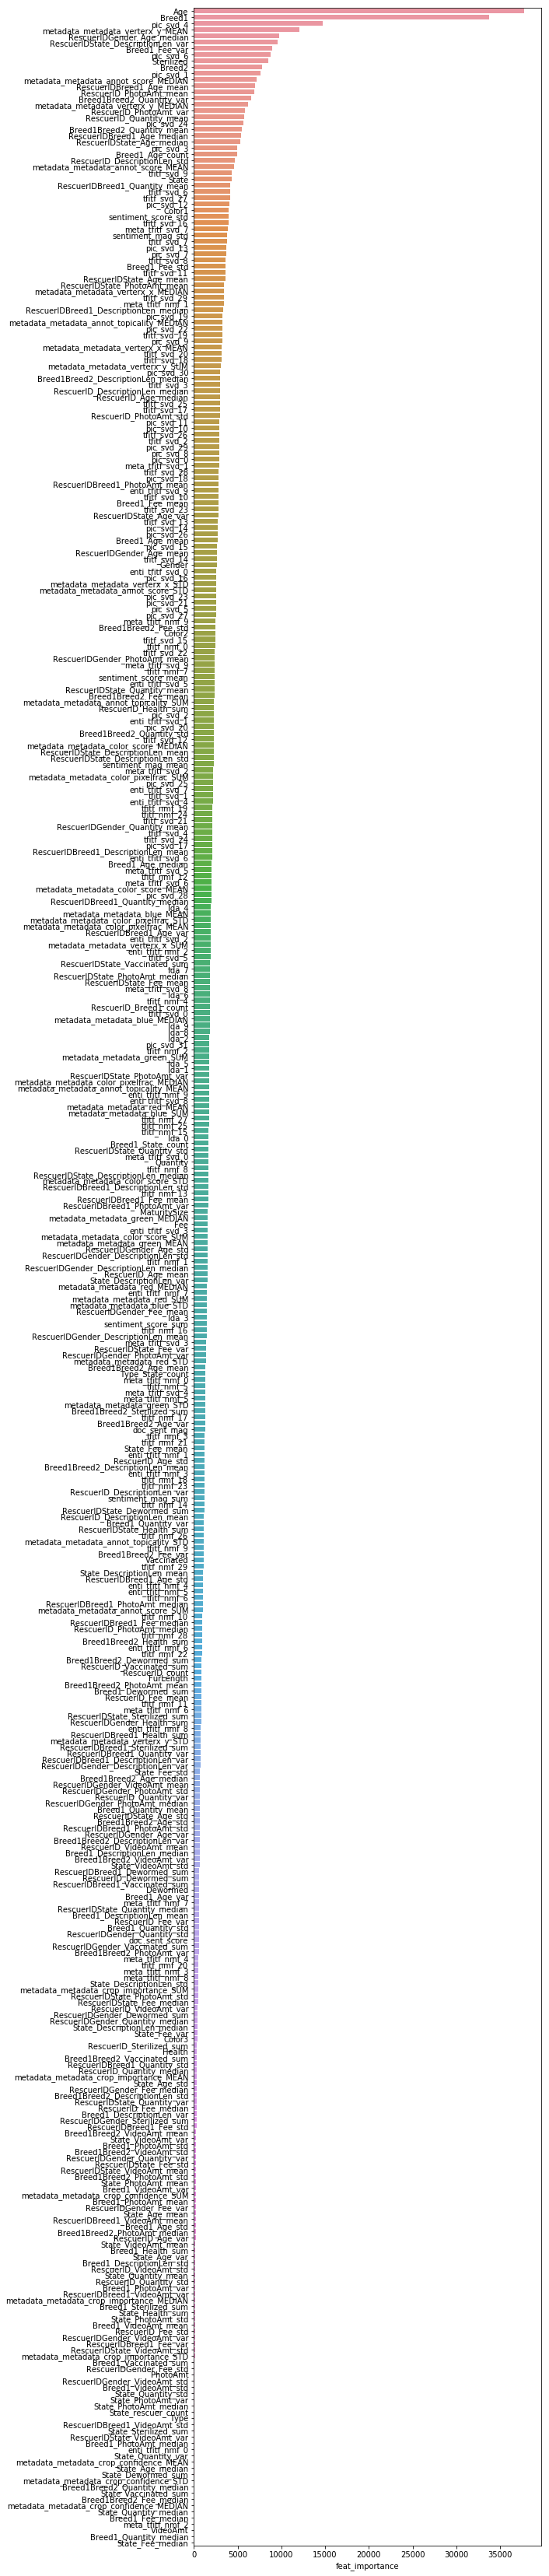

In [30]:
if plot_importance:
    feature_importances = feature_importances.T
    feature_importances.rename(columns = {0: "feat_importance"}, inplace = True)
    feature_importances = feature_importances.sort_values(by = "feat_importance", 
                                                          ascending = False)
    plt.figure(figsize = (8, 60))
    sns.barplot(feature_importances["feat_importance"], feature_importances.index)
    plt.show()

In [31]:
oof_rmse = np.sqrt(mean_squared_error(target, lgbm_oof_pred))
print("oof prediction rmse =", oof_rmse)

oof prediction rmse = 1.0468273327678597


In [32]:
opt_round = OptimizedRounder()
opt_round.fit(lgbm_oof_pred, target)
coeffs = opt_round.coefficients()
oof_pred = opt_round.predict(lgbm_oof_pred, coeffs).astype(int)
print("Target Counts = ", Counter(target))
print("Prediction Counts = ", Counter(oof_pred))
qwk = quadratic_weighted_kappa(target, oof_pred)
print("oof prediction qwk score is {}".format(qwk))

Target Counts =  Counter({4: 4197, 2: 4037, 3: 3259, 1: 3090, 0: 410})
Prediction Counts =  Counter({2: 5160, 4: 3802, 3: 3209, 1: 2252, 0: 570})
oof prediction qwk score is 0.4432987271629598


In [33]:
lgbm_test_pred = opt_round.predict(lgbm_test_pred, coeffs).astype(int)
print("Test Counts = ", Counter(lgbm_test_pred))
test["AdoptionSpeed"] = lgbm_test_pred
test[["PetID", "AdoptionSpeed"]].to_csv("submission.csv", index = False)
test[["PetID", "AdoptionSpeed"]].head()

Test Counts =  Counter({2: 1379, 4: 997, 3: 901, 1: 573, 0: 98})


,PetID,AdoptionSpeed
0,378fcc4fc,3
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,4
4,43fbba852,4
